<a href="https://colab.research.google.com/github/mongbro/colab/blob/main/10_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### keras RNN + CNN으로 음성 인식하기

1. 패키지 수입 및 파라미터 지정

In [ ]:
# 패키지 수입
import os
import numpy as np
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

from keras.utils.np_utils import to_categorical   # ont-hot-encoding 하는 함수
from keras.layers import Bidirectional, BatchNormalization  # 배치 정규화
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv1D, Input, MaxPool1D
from keras.models import Model        # Sequential 안씀

In [ ]:
# 파라미터 지정
MY_SPLIT = 0.8
MY_HIDDEN = 128
MY_DROP = 0.3
MY_BATCH = 128
MY_EPOCH = 100
MY_PATH = '/content/drive/MyDrive/Colab Notebooks/data/audio'

# 모드 선택
READ_WAV = 0
TRAIN_MODE = 1

# 파이썬 리스트 초기화
all_wave = []
all_label = []

2. 데이터 처리

[ 0.00045734  0.00092356  0.00115384 ...  0.00073417 -0.00068279
 -0.0008395 ]
22050


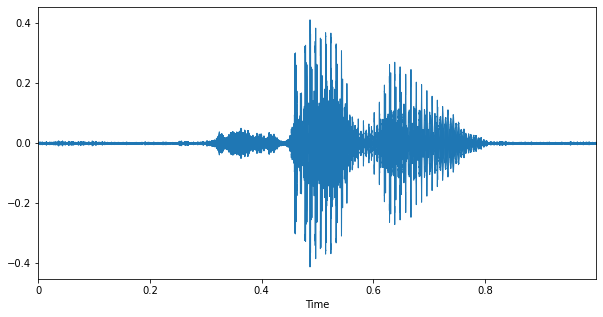

In [ ]:
# 5가지 음성에 라벨 달기
labels = ['go', 'happy', 'seven', 'stop', 'yes']

# 샘플 오디오 파일
sound, rate = librosa.load('/content/drive/MyDrive/Colab Notebooks/data/test.wav')
print(sound)
print(rate)     # rate == len(sound)

# 오디오 파일 시각화
plt.figure(figsize = (10,5))
librosa.display.waveplot(sound, rate)

In [ ]:
# 오디오 파일 읽고 처리
def read_wave():
    print('resampling 시작')    # pad_sequence를 하면 중간에 0이 들어가기때문에
                                # 소리 중간에 빈 공음이 들어간다.
    begin = time()

    # tqdm 함수로 진행 상황 출력
    for label in tqdm(labels):
        path = MY_PATH + '/' + label    # 해당 라벨 폴더의 이름(.....drive/audio/**)
        waves = [f for f in os.listdir(path)]
        
        for wav in waves:
            file = path + '/' + wav
            sound, rate = librosa.load(file)
            
            # 8kHz로 다운 샘플링
            new = librosa.resample(sound,
                                   orig_sr = rate,
                                   target_sr = 8000)

            # 성공적인 8kHz 샘플만 저장
            if(len(new) == 8000):
                all_wave.append(new)
                all_label.append(label)
    end = time()
    print('\n다운 샘플링 시간 : {:.2f}초'.format(end - begin))

In [ ]:
# 라벨 처리
def do_label():
    global all_label, all_wave

    encoder = LabelEncoder()
    tmp = encoder.fit_transform(all_label)
    all_label = to_categorical(tmp, len(labels))

    # 음성 데이터를 3차원으로 변환 => 채널 정보 추가하기 위해서
    all_wave = np.array(all_wave)
    all_wave = all_wave.reshape(-1, 8000, 1)
    #total = all_wave.shape[0]
    #all_wave = all_wave.reshape(total, 8000, 1)
          # reshape을 사용하는 두 라인은 같은 내용이다.
          # total(all_wave.shape[0])을 상수로 사용하면 안된다
          # 나중에 음성 데이터를 추가하거나 제거하면 숫자가 달라짐
    print(all_wave.shape)

In [ ]:
# 데이터 처리 모드
if READ_WAV:
    read_wave()
    do_label()

    with open('arrays.npy', 'wb') as f:
        np.save(f, all_wave)
        np.save(f, all_label)
    
    print('데이터 처리 끝')
    print('READ_WAV를 0으로 바꾸고 진행하세요')
    
else:
    with open('/content/drive/MyDrive/Colab Notebooks/data/arrays.npy', 'rb') as f:
        all_wave = np.load(f)
        all_label = np.load(f)

# 데이터 모양 출력
print('음성 데이터 :', all_wave.shape)
print('라벨 정보 :', all_label.shape)

음성 데이터 : (889, 8000, 1)
라벨 정보 : (889, 5)


In [ ]:
# 데이터 사분할
X_train, X_test, Y_train, Y_test = train_test_split(all_wave,
                                                    all_label,
                                                    train_size = MY_SPLIT,
                                                    shuffle = True)
                            # 데이터가 순서대로 뭉쳐져 있기 때문에
                            # 셔플을 반드시 해줘야 한다.

# 데이터 모양 확인
print('학습용 입력 데이터 모양 :', X_train.shape)
print('학습용 출력 데이터 모양 :', Y_train.shape)

print('평가용 입력 데이터 모양 :', X_test.shape)
print('평가용 출력 데이터 모양 :', Y_test.shape)

학습용 입력 데이터 모양 : (711, 8000, 1)
학습용 출력 데이터 모양 : (711, 5)
평가용 입력 데이터 모양 : (178, 8000, 1)
평가용 출력 데이터 모양 : (178, 5)


3. 인공 신경망 구현

In [ ]:
# Sequencial이 아니라 Model을 사용하는 방법
                        ##########################
                        #   출력(x) <= 입력      #
                        #        └---------┐   #
                        #   출력(y) <= 입력(x)   #
                        #        └---------┐   #
                        #   출력(z) <= 입력(y)   #
                        ##########################

# CNN 구현
# 입력층 (1번 블록)
my_input = Input(shape = (8000, 1))     # 출력 : inputs
x = BatchNormalization()(my_input)      # 입력 : inputs

# 첫번째 합성곱 (2번 블록)
x = Conv1D(filters = 8,
           kernel_size = 13,
           padding = 'valid',
           strides = 1,
           activation = 'relu')(x)    # (x)는 입력층에 있던 x
x = MaxPool1D(pool_size = 3)(x)       # (x)는 위에서 Conv1D 했던 x
x = Dropout(rate = MY_DROP)(x)        # (x)는 위에서 MaxPool 했던 x

# 두번째 합성곱 (3번 블록)
x = Conv1D(filters = 16,
           kernel_size = 11,
           padding = 'valid',
           strides = 1,
           activation = 'relu')(x)    # (x)는 첫번째에서 나온 x
x = MaxPool1D(pool_size = 3)(x)       # (x)는 위에서 Conv1D 했던 x
x = Dropout(rate = MY_DROP)(x)        # (x)는 위에서 MaxPool 했던 x

# 세번째 합성곱 (4번 블록)
x = Conv1D(filters = 32,
           kernel_size = 9,           # 커널을 떨어뜨리는건 그냥 이유 없음
           padding = 'valid',
           strides = 1,
           activation = 'relu')(x)    # (x)는 두번째에서 나온 x
x = MaxPool1D(pool_size = 3)(x)       # (x)는 위에서 Conv1D 했던 x
x = Dropout(rate = MY_DROP)(x)        # (x)는 위에서 MaxPool 했던 x
x = BatchNormalization()(x)           # (x)는 위에서 Dropout 했던 x

############################### 여기까지 CNN ###############################
# RNN (5번 블록)
# 첫번째 RNN/GRU 층
x = Bidirectional(GRU(units = MY_HIDDEN,
                      return_sequences = True),
                  merge_mode = 'sum')(x)      # (x)는 CNN에서 나온 x

# 두번째 RNN/GRU 층
x = Bidirectional(GRU(units = MY_HIDDEN,
                      return_sequences = True),
                  merge_mode = 'sum')(x)      # (x)는 첫번째 GRU에서 나온 x

# 세번째 RNN/GRU 층
x = Bidirectional(GRU(units = MY_HIDDEN,
                      return_sequences = False),
                  merge_mode = 'sum')(x)      # (x)는 두번째 GRU에서 나온 x

############################# 여기까지 RNN(GRU) #############################

# DNN 으로 마무리(6번 블록)
x = BatchNormalization()(x)
x = Dense(units = 256,
          activation = 'relu')(x)
my_output = Dense(units = len(labels),
                  activation = 'softmax')(x)

############################# 여기까지 DNN #############################

# 전체 인공 신경망 출력
model = Model(inputs = my_input,
              outputs = my_output)
print('인공 신경망 요약')
model.summary()

인공 신경망 요약
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)       

4. 인공 신경망 학습

In [ ]:
# CNN + RNN + DNN 학습
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

# 학습 시작
print('학습 시작')
begin = time()

model.fit(x = X_train, 
          y = Y_train,
          epochs = MY_EPOCH,
          batch_size = MY_BATCH,
          verbose = 0)

end = time()

print('학습 시간 : {:.2f}초'.format(end - begin))

학습 시작
학습 시간 : 83.17초


5. 인공 신경망 평가

In [ ]:
# CNN + RNN + DNN 평가
score = model.evaluate(x = X_test, y = Y_test,
                       verbose = 1)

print('최종 손실값 : {:.2f}'.format(score[0]))
print('최종 정확도 : {:.2f}'.format(score[1]))

6/6 [==============================] - 2s 29ms/step - loss: 0.4670 - acc: 0.9101
최종 손실값 : 0.47
최종 정확도 : 0.91


6. 인공 신경망 예측

In [ ]:
# 주어진 음성을 단어로 전환
def audio_to_text(audio):
    new = audio.reshape(1, 8000, 1)
    pred = model.predict(new)
    pred = pred.argmax(axis = 1)
    return pred

print('추측 :', audio_to_text(X_test[0]))
print('정답 :', Y_test[0])
# ['go', 'happy', 'seven', 'stop', 'yes']

추측 : [1]
정답 : [0. 0. 0. 1. 0.]


In [ ]:
# 내(교수님) 음성 인식하기
audio, rate = librosa.load('/content/drive/MyDrive/Colab Notebooks/data/SKL-yes.wav')
print(rate)

# 내 목소리 resampling
audio = librosa.resample(audio, 
                         orig_sr = rate,
                         target_sr = 8000)
print(len(audio))

# 8kHz로 패딩
audio = np.append(audio, np.zeros(118))
print(len(audio))

# 예측
pred = audio_to_text(audio)
print(pred)
# ['go', 'happy', 'seven', 'stop', 'yes']

22050
7882
8000
[4]
